In [1]:
%%capture --no-display
%pip install logkicker
%pip install ipympl mplcursors seaborn openpyxl
%matplotlib widget
import matplotlib as mpl

font = {
    'family': 'serif',
    'color':  '#02082e',
    'weight': 'normal',
    'size': 12,
}
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.family'] = 'serif'


import matplotlib.pyplot as plt
import mplcursors
plt.ion()


import pandas as pd
pd.options.mode.copy_on_write = True 

import seaborn as sns
import numpy as np

In [2]:
from compactblocks.stats import received_stats, sent_stats, sent_already_over_stats

# Prefilling Node
This data was gathered from the node that sends prefilled compact blocks to its peers.

In [3]:
# Load prefilling node data into Dataframes
prefillerxlsx = "prefiller.xlsx"
# Each xlsx file contains two datasheets, one with data about received blocks and one with data about sent blocks
prefiller_received = pd.read_excel(prefillerxlsx, sheet_name='received')
prefiller_sent = pd.read_excel(prefillerxlsx, sheet_name='sent')

## CMPCTBLOCK's received
Because this node is otherwise unmodified, we can use its measurements as a baseline for block reconstruction on nodes today.

In [4]:
received_stats(prefiller_received)

1101 out of 2883 blocks received failed reconstruction. (38.19%)
Reconstruction rate was 61.81%
Avg size of received block: 15957.20
Avg bytes missing from received blocks: 47849.36
Avg reconstruction time: 25.741588ms


In [5]:
### Histograms of reconstruction times for transactions with

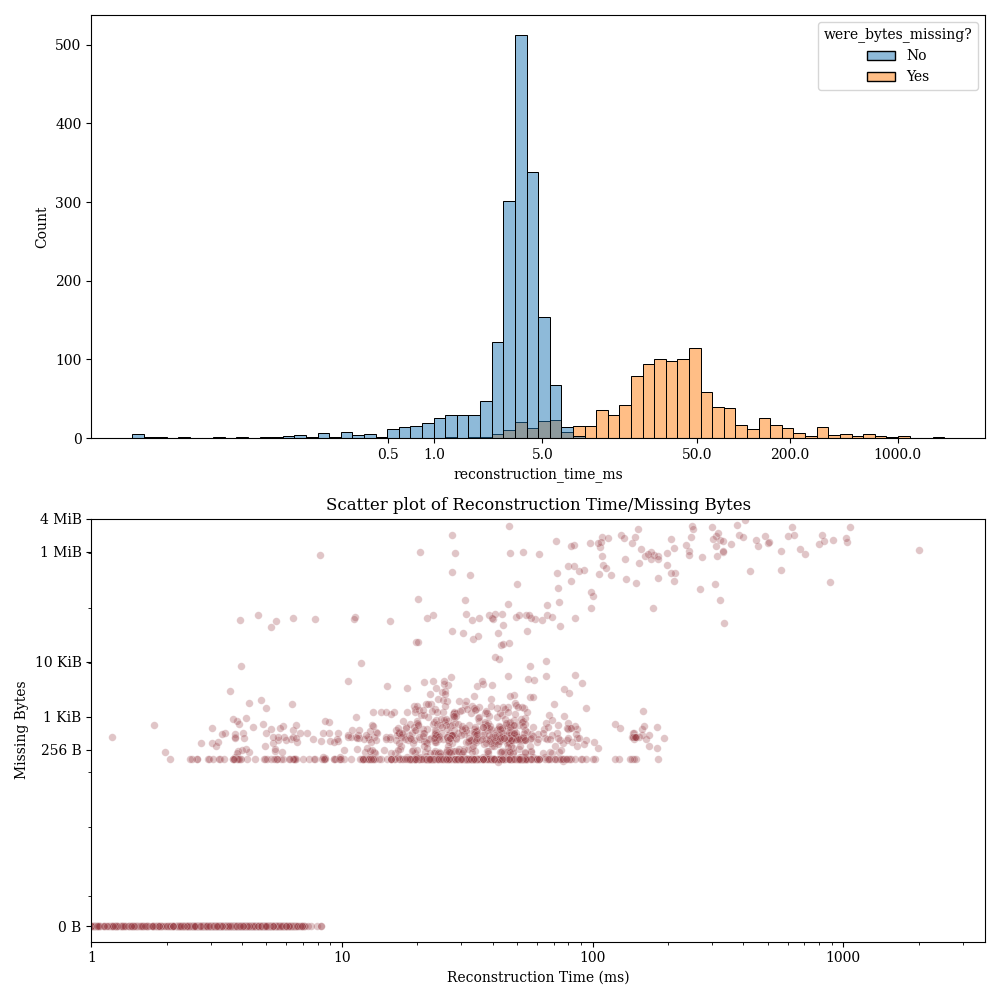

In [6]:
# Plot reconstruction time histogram and bytesmissing/reconstructiontime scatterplot
histcolor = "#749940"
prefiller_received['reconstruction_time_ms'] = prefiller_received['reconstruction_time_ns'] / 1_000_000
prefiller_received['were_bytes_missing?'] = np.where(prefiller_received['bytes_missing'] > 0, 'Yes', 'No')

f, [ax1, ax2] = plt.subplots(2, figsize=(10,10), tight_layout=True)
# Histplot on top
sns.histplot(data=prefiller_received, x='reconstruction_time_ms', hue='were_bytes_missing?', ax=ax1, color=histcolor, log_scale=2, bins=70)
ax1.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax1.set_xticks([0.5, 1, 5, 50, 200, 1000])


histcolor = "#749940"

# Scatterplot on bottom "
scattercolor = "#994047"
xticks = [1, 10, 50, 100, 1000]
yticks_bytes = [0, 256, 1024, 10*1024, 1024*1024, 4*1024*1024] # 256B, 1KB, 10KB, 100KB, 1MB, 4MB
ytick_labels = ['0 B', '256 B', '1 KiB', '10 KiB', '1 MiB', '4 MiB']
sns.scatterplot(data=prefiller_received, x='reconstruction_time_ms', y='bytes_missing', 
                ax=ax2, color=scattercolor, alpha=0.3, s=30)


ax2.set_title('Scatter plot of Reconstruction Time/Missing Bytes')

ax2.set_xlabel('Reconstruction Time (ms)')
ax2.set_xticks(xticks)
ax2.set_xscale('log') 
ax2.set_xlim(left=1)
ax2.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax2.set_ylim(-0.5)
ax2.set_ylabel('Missing Bytes')
ax2.set_yscale('symlog') 
ax2.set_yticks(yticks_bytes)
ax2.set_yticklabels(ytick_labels)

plt.show()

## CMPCTBLOCK's sent
The most important data in this particular observation period is here, the notable headline is that 85.78% of the prefilled blocks we sent fit in the available TCP window buffer.

In [7]:
sent_stats(prefiller_sent)

17536/26392 blocks were sent with prefills. (66.44%)
Avg available prefill bytes for all CMPCTBLOCK's we sent: 8679.14
Avg available prefill bytes for prefilled CMPCTBLOCK's we sent: 8362.04
Avg total prefill size for CMPCTBLOCK's we prefilled: 74593.04
15042/17536 prefilled blocks sent fit in the available bytes. (85.78%)


The average prefill size is notably large, but this is a consequence of unrepresentatively large blocks.

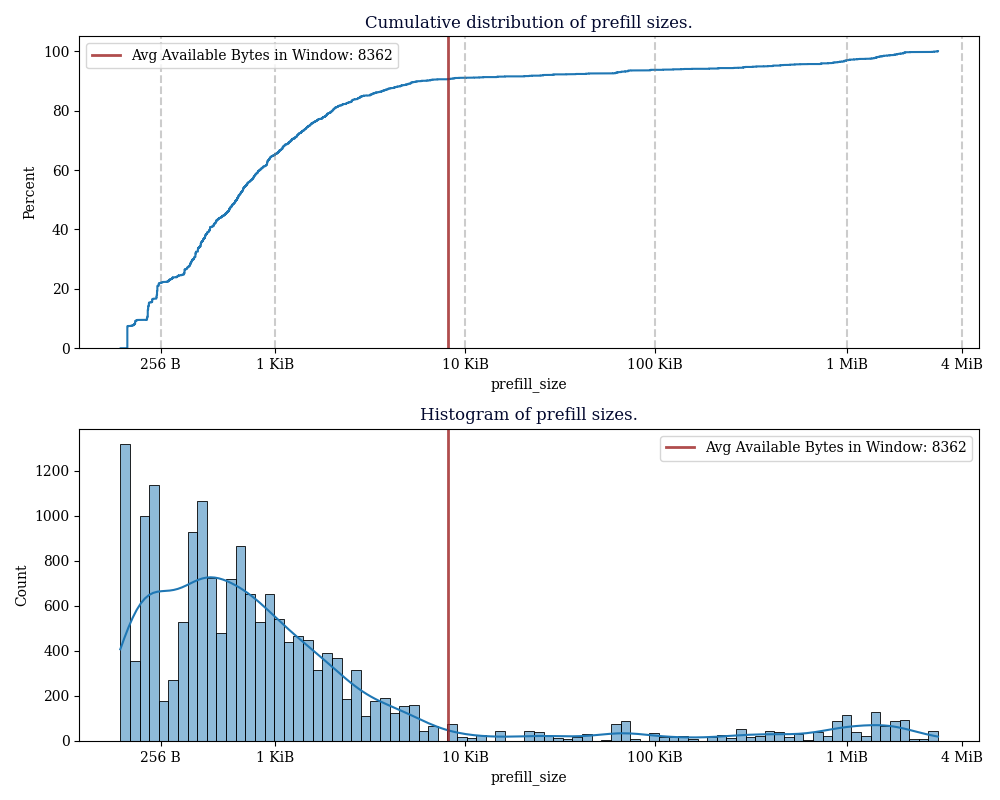

In [8]:
# Plot distribution of prefill sizes

prefilled_sends = prefiller_sent[prefiller_sent['prefill_size'] > 0]

xticks = [256, 1024, 10*1024, 100*1024, 1024*1024, 4*1024*1024]
xtick_labels = ['256 B', '1 KiB', '10 KiB', '100 KiB', '1 MiB', '4 MiB']
# Special red vertical line for the average available space for prefill
avg_prefill_size = prefilled_sends['window_bytes_available'].mean()
avg_prefill_line = {
    'x': avg_prefill_size,
    'color': '#9c2020',
    'alpha': 0.8,
    'linestyle': '-',
    'linewidth': 2,
    'label': f"Avg Available Bytes in Window: {avg_prefill_size:.0f}",
}

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8), tight_layout=True)
sns.ecdfplot(data=prefilled_sends, x="prefill_size", log_scale=2, stat='percent', ax=ax1)
ax1.set_title('Cumulative distribution of prefill sizes.', fontdict=font)
ax1.set_xticks(xticks)
# Draw vertical lines at each tick
for xtick in xticks:
    ax1.axvline(x=xtick, color='gray', linestyle='--', alpha=0.4)
ax1.set_xticklabels(xtick_labels)

ax1.axvline(**avg_prefill_line)
ax1.legend()

sns.histplot(data=prefilled_sends, x="prefill_size", log_scale=2, ax=ax2, kde=True)
ax2.set_title('Histogram of prefill sizes.', fontdict=font)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xtick_labels)

ax2.axvline(**avg_prefill_line)
ax2.legend()

#mplcursors.cursor([ax1, ax2], hover=True)

plt.show()


### `vExtraTxnForCompact`
But, we can probably do even better, since the above statistics are for prefilling *with* all of the transactions in `vExtraTxnForCompactBlock`, and as I understand, it is very likely for peers running the same branch of Bitcoin Core to have a similar `vExtraTxnForCompactBlock`'s to one another. So it is likely that reconstruction will often succeed even without these transactions, so they should be the first candidates for not being included in the prefill. Unfortunately, their size is not something that Bitcoin Core logs, although I tried to compute it with a heuristic: `prefill_size - missing_txns_we_requested_size`, but it turned out this was very incorrect.

### Excessively large before prefill
Interestingly, some compact blocks were already so large *before* prefilling that they required more than one TCP round-trip to be sent, while this circumstance is not ideal, prefilling performs better by taking advantage of this.


In [9]:
sent_already_over_stats(prefiller_sent)

1432/26392 CMPCTBLOCK's sent were already over the window for a single RTT before prefilling. (5.43%)
Avg. available bytes for prefill in blocks that were already over a single RTT: 8555.57
1432/1432 excessively large blocks had prefills that fit. (100.00%)


# Prefill Receiving Node
This data was gathered from a node configured so that it would only receive CMPCTBLOCK announcements from our prefilling node.


In [10]:
# Load prefillee node data into Dataframes
prefillreceiverxlsx = "prefillreceiver.xlsx"
# Each xlsx file contains two datasheets, one with data about received blocks and one with data about sent blocks
prefillreceiver_received = pd.read_excel(prefillreceiverxlsx, sheet_name='received')
prefillreceiver_sent = pd.read_excel(prefillreceiverxlsx, sheet_name='sent')

In [11]:
received_stats(prefillreceiver_received)

49 out of 2793 blocks received failed reconstruction. (1.75%)
Reconstruction rate was 98.25%
Avg size of received block: 55851.93
Avg bytes missing from received blocks: 603.40
Avg reconstruction time: 7.821697ms


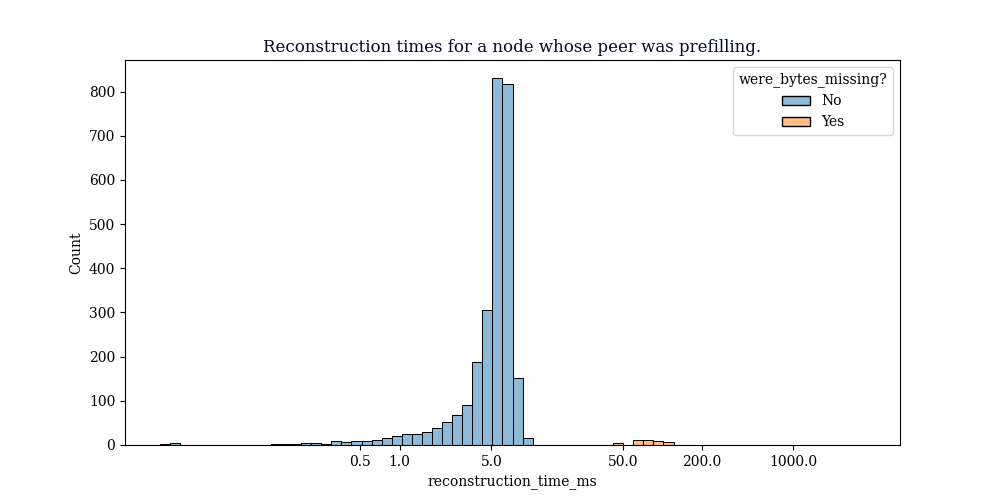

In [12]:
# Plot reconstruction time histogram and bytesmissing/reconstructiontime scatterplot
prefillreceiver_received['reconstruction_time_ms'] = prefillreceiver_received['reconstruction_time_ns'] / 1_000_000
prefillreceiver_received['were_bytes_missing?'] = np.where(prefillreceiver_received['bytes_missing'] > 0, 'Yes', 'No')
fig, ax1 = plt.subplots(figsize=(10,5))
sns.histplot(data=prefillreceiver_received, 
             x='reconstruction_time_ms', hue='were_bytes_missing?', ax=ax1, color=histcolor, 
             log_scale=2, bins=70)
scalar_with_small_powers = mpl.ticker.ScalarFormatter()
ax1.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax1.set_xticks([0.5, 1, 5, 50, 200, 1000])
ax1.set_title('Reconstruction times for a node whose peer was prefilling.', fontdict=font)
plt.show()
